## Import modules

In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

hv.notebook_extension()
%matplotlib inline

## Note: All calculations can be performed *before* load().  
## Plots require load() but can plot subset of data as a test

## Open NDVI_ll NetCDFs

In [29]:
ds_all=xr.open_mfdataset(
    '/g/data/oe9/project/team-drip/h30v12_ndvi_ll_????.nc',
    chunks=dict(time=12, latitude=200), #chunks should be in multiples of saved chunk size
)
ds_all

<xarray.Dataset>
Dimensions:                        (latitude: 1400, longitude: 3000, time: 644)
Coordinates:
  * latitude                       (latitude) float64 -30.0 -30.0 -30.01 ...
  * longitude                      (longitude) float64 138.0 138.0 138.0 ...
  * time                           (time) datetime64[ns] 2001-01-01 ...
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float64 dask.array<shape=(644, 1400, 3000), chunksize=(12, 200, 3000)>

In [48]:
ds_all=ds_all.rename({'__xarray_dataarray_variable__': 'ndvi'})

In [75]:
%%time
canberra=ds_all.sel(latitude=slice(-34, -35),longitude=slice(148,149))
canberra.load()

CPU times: user 589 ms, sys: 4.53 s, total: 5.12 s
Wall time: 38.8 s


In [76]:
img=canberra.isel(time=10).ndvi
img

<xarray.DataArray 'ndvi' (latitude: 201, longitude: 201)>
array([[0.451602, 0.511002, 0.505391, ...,      nan, 0.426767,      nan],
       [0.458474, 0.507908, 0.515133, ...,      nan,      nan,      nan],
       [0.481053, 0.516575, 0.472825, ...,      nan, 0.485694,      nan],
       ...,
       [0.380224, 0.397243, 0.35956 , ...,      nan,      nan,      nan],
       [0.314347, 0.266525, 0.272081, ...,      nan,      nan,      nan],
       [0.310572, 0.247143, 0.243231, ..., 0.331092, 0.310378,      nan]])
Coordinates:
  * latitude   (latitude) float64 -34.0 -34.01 -34.01 -34.02 -34.02 -34.02 ...
  * longitude  (longitude) float64 148.0 148.0 148.0 148.0 148.0 148.0 148.0 ...
    time       datetime64[ns] 2001-02-10

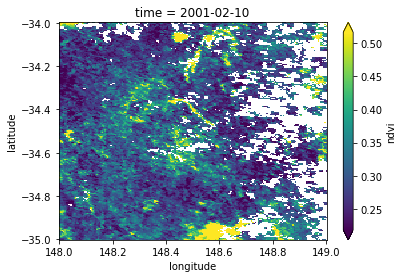

In [78]:
img.plot.imshow(robust=True)

In [66]:
out.diff('time').plot.imshow(col='time', robust=True)

<xarray.DataArray (latitude: 1400, longitude: 3000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 -30.0 -30.0 -30.01 -30.02 -30.02 -30.02 ...
  * longitude  (longitude) float64 138.0 138.0 138.0 138.0 138.0 138.0 138.0 ...

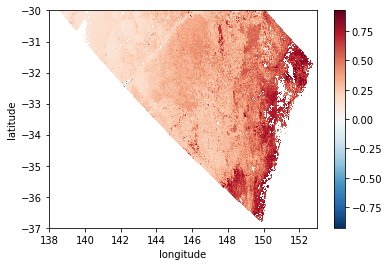

In [65]:
ll.plot.imshow()

## Manipulation via time.season & groupby()

In [21]:
#like accumarray, group by season and perform function
# creates seasonal averages for whole time series
seasonal = ndvi.groupby('time.season').mean(dim='time')
seasonal


<xarray.DataArray (season: 4, y: 1680, x: 2400)>
dask.array<shape=(4, 1680, 2400), dtype=float32, chunksize=(1, 1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [22]:
#create seasonal object by extracting from seasonal dataarray
nJJA=seasonal.sel(season='JJA')
nDJF=seasonal.sel(season='DJF')
nJJA

<xarray.DataArray (y: 1680, x: 2400)>
dask.array<shape=(1680, 2400), dtype=float32, chunksize=(1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
    season   <U3 'JJA'

In [ ]:
climatology = ndvi.groupby('time.month').mean('time')
climatology

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


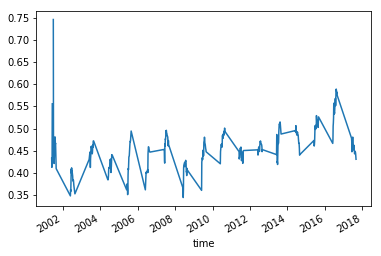

In [15]:
%%time
#extract all timesteps in a given season
ndvi_jja=ndvi.sel(time=ndvi['time.season']=='JJA')
ndvi_jja_m=ndvi_jja.mean(dim=('x','y'))
ndvi_jja_m.plot()

## Play with resampling aliases to create yearly seasonal averages

In [42]:
#resample dataset to quarterly with year ending in Nov, resample by meaning included timesteps
ndvi_rs=ndvi.resample('M').mean(dim='time')
ndvi_rs=ndvi.resample(time='time.season').mean(dim='time')
ndvi_rs


/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<xarray.DataArray (time: 69, y: 1680, x: 2400)>
dask.array<shape=(69, 1680, 2400), dtype=float32, chunksize=(1, 1680, 1200)>
Coordinates:
  * time     (time) datetime64[ns] 2001-02-28 2001-05-31 2001-08-31 ...
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...

In [32]:
ndvi_jja=ndvi_rs.where(ndvi_rs['time.season']=='JJA', drop=True)
ndvi_jja_m=ndvi_jja.mean(dim=('x','y'))
ndvi_djf=ndvi_rs.where(ndvi_rs['time.season']=='DJF', drop=True)
ndvi_djf_m=ndvi_jja.mean(dim=('x','y'))
ndvi_djf.time


<xarray.DataArray 'time' (time: 18)>
array(['2001-02-28T00:00:00.000000000', '2002-02-28T00:00:00.000000000',
       '2003-02-28T00:00:00.000000000', '2004-02-29T00:00:00.000000000',
       '2005-02-28T00:00:00.000000000', '2006-02-28T00:00:00.000000000',
       '2007-02-28T00:00:00.000000000', '2008-02-29T00:00:00.000000000',
       '2009-02-28T00:00:00.000000000', '2010-02-28T00:00:00.000000000',
       '2011-02-28T00:00:00.000000000', '2012-02-29T00:00:00.000000000',
       '2013-02-28T00:00:00.000000000', '2014-02-28T00:00:00.000000000',
       '2015-02-28T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2017-02-28T00:00:00.000000000', '2018-02-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-02-28 2002-02-28 2003-02-28 ...

In [45]:
ndvi_jja.time

<xarray.DataArray 'time' (time: 17)>
array(['2001-08-31T00:00:00.000000000', '2002-08-31T00:00:00.000000000',
       '2003-08-31T00:00:00.000000000', '2004-08-31T00:00:00.000000000',
       '2005-08-31T00:00:00.000000000', '2006-08-31T00:00:00.000000000',
       '2007-08-31T00:00:00.000000000', '2008-08-31T00:00:00.000000000',
       '2009-08-31T00:00:00.000000000', '2010-08-31T00:00:00.000000000',
       '2011-08-31T00:00:00.000000000', '2012-08-31T00:00:00.000000000',
       '2013-08-31T00:00:00.000000000', '2014-08-31T00:00:00.000000000',
       '2015-08-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2017-08-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-08-31 2002-08-31 2003-08-31 ...

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 11min 4s, sys: 1min 2s, total: 12min 7s
Wall time: 10min 50s


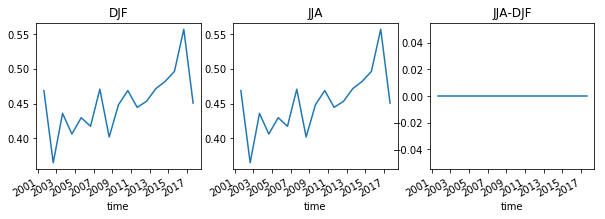

In [44]:
%%time
fig=plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
ndvi_djf_m.plot()
plt.title('DJF')
plt.subplot(1,3,2)
ndvi_jja_m.plot()
plt.title('JJA')
plt.subplot(1,3,3)
diff=ndvi_jja_m-ndvi_djf_m;
diff.plot()
plt.title('JJA-DJF')

## Plotting slices

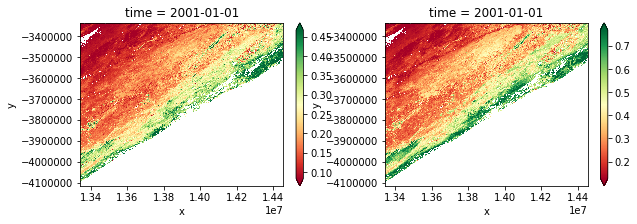

In [15]:
##plot
fig=plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.title('h30v12')
evi.isel(time=0).plot.imshow(robust=True,cmap='RdYlGn')

plt.subplot(1,2,2)
ndvi.isel(time=0).plot.imshow(robust=True,cmap='RdYlGn')

In [ ]:
seasonal.plot.imshow(col='season', robust=True, cmap='RdYlGn')

In [ ]:
%%time
gseas = gv.Dataset(seasonal, kdims=['x', 'y', 'season'], vdims=['evi'],rs=crs.PlateCarree())
gseas.to(gv.Image, ['x', 'y'])

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: inva

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel/ip

In [ ]:
fig, axes = plt.subplots(ncols=2)
ndvi.isel(time=0).plot.imshow(ax=axes[0])
ndvi_ll.isel(time=0).plot.imshow(ax=axes[1])
plt.tight_layout()